In [1]:
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
from sklearn.model_selection import train_test_split
from helper.utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
X_train, y_train = input_converter(merged_data, train_data)
X_val, y_val = input_converter(merged_data, val_data)
X_test, y_test = input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)

In [7]:
num_words = len(words)
num_tags = len(tags)
max_len = 100
model = blstm_model(num_words, num_tags, max_len)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1344500   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 50)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 100, 200)         120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 7)           1407      
 ibuted)                                                         
                                                             

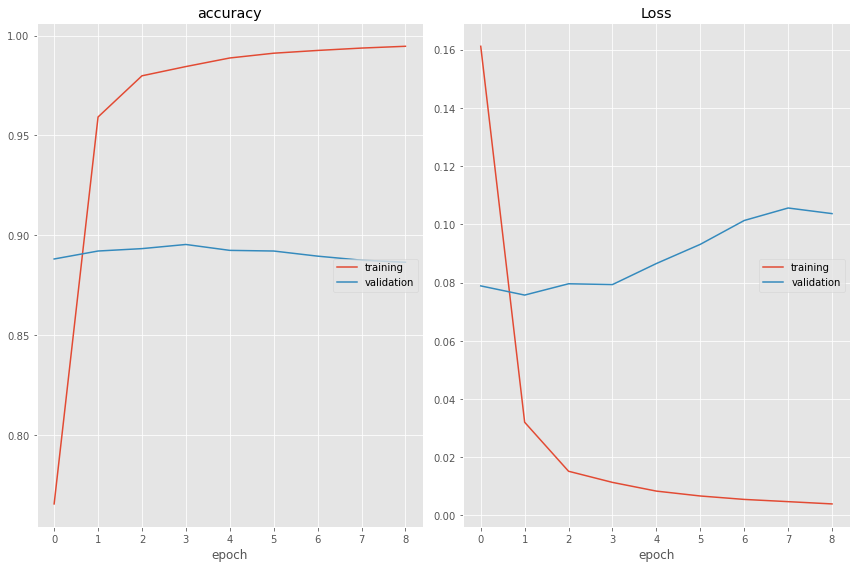

accuracy
	training         	 (min:    0.766, max:    0.995, cur:    0.995)
	validation       	 (min:    0.887, max:    0.895, cur:    0.887)
Loss
	training         	 (min:    0.004, max:    0.161, cur:    0.004)
	validation       	 (min:    0.076, max:    0.106, cur:    0.104)

Epoch 9: val_loss did not improve from 0.07569
56/56 [==============================] - 2s 27ms/step - loss: 0.0980 - accuracy: 0.8902
[0.09798336774110794, 0.8901739120483398]


In [8]:
root_path = 'model/'
model_name = 'blstm_model.h5'
num_epoch = 50
callbacks = get_callbacks(root_path, model_name)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

print(model.evaluate(X_test, y_test))

In [9]:
from keras.models import load_model

mdl = load_model('model/blstm_model.h5')

In [10]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_test)):
    p = mdl.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_test[i], y_true, p[0]):
        if words[w-1] != "ENDPAD":
            # print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))
            w_pair.append(words[w-1])
            true_pair.append(tags[true])
            pred_pair.append(tags[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

In [11]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.8878    0.9624    0.9236     22309
          JV     0.8874    0.7877    0.8346      4914
          EN     0.9170    0.8295    0.8710      5020
   MIX-ID-EN     0.9305    0.8253    0.8747       973
   MIX-ID-JV     0.9816    0.7607    0.8571       280
   MIX-JV-EN     0.9153    0.8195    0.8648       277
           O     0.8946    0.8380    0.8654     10151

    accuracy                         0.8937     43924
   macro avg     0.9163    0.8319    0.8702     43924
weighted avg     0.8944    0.8937    0.8923     43924



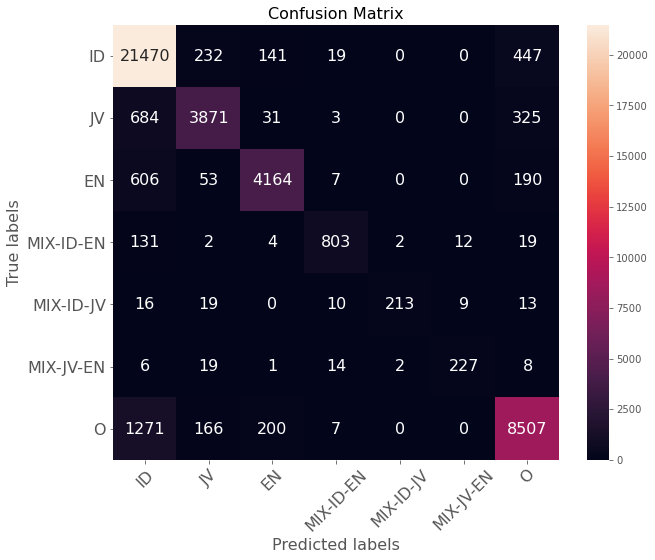

In [12]:
performance_report(true_flat, pred_flat)

In [13]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})

In [14]:
token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)

In [15]:
true_pred_file = 'tagging_result/compare_results_blstm.tsv'
with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")

    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()

In [16]:
i = np.random.randint(0, X_test.shape[0]) #659
p = mdl.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    if words[w-1] != "ENDPAD":
        print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))

Word                          True      	 Pred

------------------------------------------------------------
oyi                           JV        	JV
rek                           JV        	JV
penjual                       ID        	ID
ayam                          ID        	ID
potong                        ID        	ID
di                            ID        	ID
pasar                         ID        	ID
itu                           ID        	ID
mau                           ID        	ID
apa                           ID        	ID
engga                         ID        	ID
ya                            ID        	ID
kalo                          ID        	ID
misal                         ID        	ID
kita                          ID        	ID
beline                        MIX-ID-JV 	MIX-ID-JV
fillet                        EN        	ID
?                             O         	O
spill                         EN        	EN
dipasar                       ID        	ID
mana 

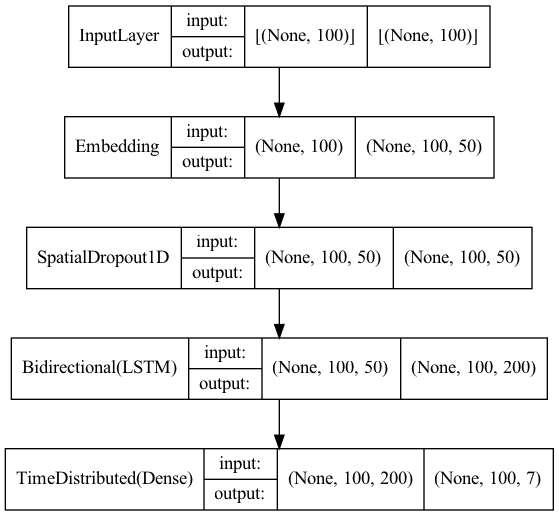

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot/tr_blstm.png', show_shapes=True, show_layer_names=False)